# In this project, you will acting as a machine learning engineer or researcher at a healthcare company specializing in medical imaging applications. The team in which you are working want to perform the analysis of MRIs (Magnetic Resonance Images) of brain. An MRI system can create multiple types of images at one go but not all types of images are aquired in every single time,in every single scan. In short, MRI system gives us two types of images as output for every patient. One is called T1 weighted images and other one is called T2 weighted images. But in many scenarios, it can happen with people that they may lost one of those images given to them as their test report but the diagnostician requires both types of images to diagnose that what is going on with the patient inside his brain.

# In this project, we are assuming that patients might be having T1 weighted images with them in their test report images but they may lost the T2 weighted images. So, your task is to generate synthetic artificial T2 weighted images for them, given their respective T1 weighted images so that their test reports will be having both kind of images and hence it will be easier for the diagnostician to diagnose their disease. You will be using deep learning for this.



In [ ]:
! pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Make sure that nibabel library is installed. This library is used to read different types of images in medical domain in python. To know more about Nibabel library, goto the following link:

# https://nipy.org/nibabel/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/T1_and_T2_weighted_training_images.zip ./

# Make sure that you have already navigated to google drive because you will be unzipping lot of biomemdical images in your google drive. You can download the data from the following link:

# https://drive.google.com/file/d/1DjEwIGOIHzGJ8_VWNiZMxxIHSHVeBN0s/view?usp=sharing

In [ ]:
! unzip /content/T1_and_T2_weighted_training_images.zip

Archive:  /content/T1_and_T2_weighted_training_images.zip
   creating: T1_and_T2_weighted_training_images/
   creating: T1_and_T2_weighted_training_images/t1/
 extracting: T1_and_T2_weighted_training_images/t1/IXI102-HH-1416-T1_fcm.nii.gz  
 extracting: T1_and_T2_weighted_training_images/t1/IXI104-HH-1450-T1_fcm.nii.gz  
 extracting: T1_and_T2_weighted_training_images/t1/IXI105-HH-1471-T1_fcm.nii.gz  
 extracting: T1_and_T2_weighted_training_images/t1/IXI126-HH-1437-T1_fcm.nii.gz  
 extracting: T1_and_T2_weighted_training_images/t1/IXI127-HH-1451-T1_fcm.nii.gz  
 extracting: T1_and_T2_weighted_training_images/t1/IXI128-HH-1470-T1_fcm.nii.gz  
 extracting: T1_and_T2_weighted_training_images/t1/IXI130-HH-1528-T1_fcm.nii.gz  
 extracting: T1_and_T2_weighted_training_images/t1/IXI131-HH-1527-T1_fcm.nii.gz  
 extracting: T1_and_T2_weighted_training_images/t1/IXI132-HH-1415-T1_fcm.nii.gz  
 extracting: T1_and_T2_weighted_training_images/t1/IXI136-HH-1452-T1_fcm.nii.gz  
 extracting: T1_and_T

# A medical image is read using nibabel library as shown below

In [ ]:
import nibabel as nib
patient_t1_image =  nib.load("/content/drive/MyDrive/Colab_Notebooks/T1_and_T2_weighted_training_images/t1/IXI102-HH-1416-T1_fcm.nii.gz")
patient_t1_image_data = patient_t1_image.get_fdata()

In [ ]:
patient_t1_image_data.shape

(120, 120, 90)

# As it can be noticed that MR Images are far different than the usual colored or grayscale images. Colored images have three channels and grayscale images have only one channel whereas it can be clearly seen that the MR images here have 90 channels !!! Thats crazy. Therefore, one thing is for sure that definitely these images will comsume lot of memory and computation time when passed though a Convolutional Neural Network because their size (Height and Width) is also big as well as their number of channels are also a lot.

In [ ]:
patient_t2_image = nib.load("/content/T1_and_T2_weighted_training_images/t2/IXI102-HH-1416-T2_reg_fcm.nii.gz")
patient_t2_image_data = patient_t2_image.get_fdata()

In [ ]:
patient_t2_image_data.shape

(120, 120, 90)

# Previously, T1 eighted image of one of the patients is read using nibabel library and here wera are reading T2 weighted image of the same patient using nibabel library.

# Now, let's try to see that what is inside these two types of images for a single patient. But, all our eyes can see are colored images and we know that colored images have maximum 3 channels (R,G,B) or our eyes can see a grayscale (Black and White) image so it means that our eyes can see images which have maximum 3 channels but the medicalimages we have of brain have 90 channels !!! So, how do we visualize them ??  Well, what we are goiong to do is that we are going to randomly select 3 consecutive channels out of 90 channels and going to plot and see that what we can observe.

In [ ]:
import matplotlib.pyplot as plt

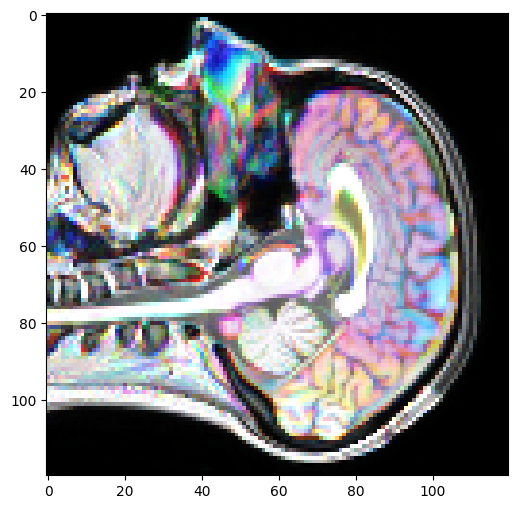

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(patient_t1_image_data[:,:,44:47])

# Above is the plot of randomly selected 3 channels of T1 weighted images and below is the plot of same 3 consecutive selected channels of T2 weighted image as T1 weighted image.

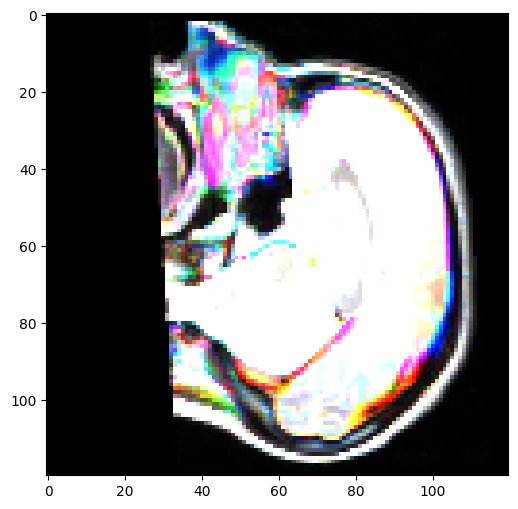

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(patient_t2_image_data[:,:,44:47])

# Now, the first thing which we have to do is to segregate our data into 3 parts : Training, Cross Validation and Testing. We already have all the images in a training folder, this means that we have to create two more folders for Cross Validation and Testing data and move some fixed fraction (Train: 70 %, Cross Validation: 20 % and Testing: 10 %) of both T1 and T2 weighted images to the respective folders.

In [ ]:
import os

In [ ]:
import shutil

In [ ]:
!pip install patchify

In [ ]:
from PIL import Image
import numpy as np
from patchify import patchify

# Now that we have segregated our T1 and T2 weighted images into three respective categories, we have to now write the function for our custom data generator. Some important points to keep in mind while creauting our custom image data generator.

# First of all, the training data is very less and in such kind of situation, if we are going to train a network to translate T1 to T2 weighted images then it will overfit because the number of parameters in a neural network will be lot more in comparison to the number of training images as well as their pixels. So, network will be more complex and hence for sure overfitting will happen.

# So, we need to increase our training data. Now, we have to two ways to increase our training data, the first is to perform data rugmentation by rotating, horizontally shifting, vertically shifting both T1 and T2 weighted images.

# The second thing which we should definitely do is to take random crops from our single image (both T1 and T2) of shape (120,120,90). But we need to fix on the size of the random crop which we are going to take from each image. And we will be feeding that into our CNN. But the question arrises is that why we need to perform random cropping of fixed size and insert it into a CNN, why not insert the whole image because we have to translate the whole image and not the part of it, right ? Well, it doesn't matters because uptimately the network is going to learn the parametrs in the same way as it will learn for the whole image but random cropping is going to be advantageous in two ways. First iof all our training data will increase because for each image in each epoch we can take a different random crop with a different set of consecutive channels as well as different set of pixels located in different locations and at the same time our cropped image will be smaller in size in comparison to the whole image and hence less memory will be consumed as well as less comutation time will be reuiqred and durig the inference time, we can always merge the copped portions to get the whole T2 translated image.

# Therefore, you have to write a function for our custom data generator such that for every spoch, our custom data generator will perform the random crop on both T1 and T2 weighted images on the same spatial locations as well as same consecutive channels and return the batch of them so that we can feed that batch to the network.

In [ ]:
def data_generator(base_path,t1_images,t2_images,crop_size,batch_size=2):

  num_images = len(t1_images)
  t1_images = np.array(t1_images)
  t2_images = np.array(t2_images)

  crop_height, crop_width, crop_depth = crop_size

  while True:

    for offset in range(0,num_images,batch_size):

      t1_batch_images = list(np.random.choice(t1_images,size=batch_size,replace=False))
      t2_batch_images = list(np.random.choice(t2_images,size=batch_size,replace=False))

      t1_images_path = os.path.join(base_path,"t1")
      t2_images_path = os.path.join(base_path,"t2")


      for t1_img,t2_img in zip(t1_batch_images,t2_batch_images):

        t1_image = nib.load(os.path.join(t1_images_path,t1_img))
        t2_image = nib.load(os.path.join(t2_images_path,t2_img))

        t1_image_data = t1_image.get_fdata()
        t2_image_data = t2_image.get_fdata()

        t1_cropped_images_batch = patchify(image=t1_image_data,patch_size=(crop_height,crop_width,crop_depth),step=30)
        t2_cropped_images_batch = patchify(image=t2_image_data,patch_size=(crop_height,crop_width,crop_depth),step=30)


        t1_cropped_images_batch = t1_cropped_images_batch.reshape(t1_cropped_images_batch.shape[0]*t1_cropped_images_batch.shape[1]*t1_cropped_images_batch.shape[2],
                                                                  t1_cropped_images_batch.shape[3],
                                                                  t1_cropped_images_batch.shape[4],
                                                                  t1_cropped_images_batch.shape[5])

        t2_cropped_images_batch = t2_cropped_images_batch.reshape(t2_cropped_images_batch.shape[0]*t2_cropped_images_batch.shape[1]*t2_cropped_images_batch.shape[2],
                                                                  t2_cropped_images_batch.shape[3],
                                                                  t2_cropped_images_batch.shape[4],
                                                                  t2_cropped_images_batch.shape[5])

        yield np.array(t1_cropped_images_batch)[...,np.newaxis], np.array(t2_cropped_images_batch)[...,np.newaxis]

In [ ]:
from keras.layers import Conv3D, Conv3DTranspose, BatchNormalization, MaxPooling3D
from keras.models import Sequential
from keras.layers import Input, UpSampling3D, UpSampling2D
from keras.layers import ReLU, Concatenate
from keras.layers import Reshape
import tensorflow as tf
import keras
from keras.models import Model

# Please download the research paper of U-net from the following link and follow the complete architecture and implement it inside the the below mentioned function:

# https://arxiv.org/abs/1505.04597

In [ ]:
def create_regression_unet(input_image_shape):

  regression_unet_input = Input(shape=input_image_shape)

  regression_unet_first_block_down = Conv3D(filters=64,kernel_size=3,use_bias=False,padding="same")(regression_unet_input)
  regression_unet_first_block_down = BatchNormalization()(regression_unet_first_block_down)
  regression_unet_first_block_down = ReLU()(regression_unet_first_block_down)

  regression_unet_first_block_down = Conv3D(filters=64,kernel_size=3,use_bias=False,padding="same")(regression_unet_first_block_down)
  regression_unet_first_block_down = BatchNormalization()(regression_unet_first_block_down)
  regression_unet_first_block_down = ReLU()(regression_unet_first_block_down)

  maxpooled_first_block_down = MaxPooling3D()(regression_unet_first_block_down)

  regression_unet_second_block_down = Conv3D(filters=128,kernel_size=3,use_bias=False,padding="same")(maxpooled_first_block_down)
  regression_unet_second_block_down = BatchNormalization()(regression_unet_second_block_down)
  regression_unet_second_block_down = ReLU()(regression_unet_second_block_down)

  regression_unet_second_block_down = Conv3D(filters=128,kernel_size=3,use_bias=False,padding="same")(regression_unet_second_block_down)
  regression_unet_second_block_down = BatchNormalization()(regression_unet_second_block_down)
  regression_unet_second_block_down = ReLU()(regression_unet_second_block_down)

  maxpooled_second_block_down = MaxPooling3D()(regression_unet_second_block_down)

  regression_unet_third_block_down = Conv3D(filters=256,kernel_size=3,use_bias=False,padding="same")(maxpooled_second_block_down)
  regression_unet_third_block_down = BatchNormalization()(regression_unet_third_block_down)
  regression_unet_third_block_down = ReLU()(regression_unet_third_block_down)

  regression_unet_third_block_down = Conv3D(filters=256,kernel_size=3,use_bias=False,padding="same")(regression_unet_third_block_down)
  regression_unet_third_block_down = BatchNormalization()(regression_unet_third_block_down)
  regression_unet_third_block_down = ReLU()(regression_unet_third_block_down)

  maxpooled_third_block_down = MaxPooling3D()(regression_unet_third_block_down)

  regression_unet_forth_block_down = Conv3D(filters=512,kernel_size=3,use_bias=False,padding="same")(maxpooled_third_block_down)
  regression_unet_forth_block_down = BatchNormalization()(regression_unet_forth_block_down)
  regression_unet_forth_block_down = ReLU()(regression_unet_forth_block_down)

  regression_unet_forth_block_down = Conv3D(filters=512,kernel_size=3,use_bias=False,padding="same")(regression_unet_forth_block_down)
  regression_unet_forth_block_down = BatchNormalization()(regression_unet_forth_block_down)
  regression_unet_forth_block_down = ReLU()(regression_unet_forth_block_down)

  maxpooled_forth_block_down = MaxPooling3D()(regression_unet_forth_block_down)

  regression_unet_fifth_block_down = Conv3D(filters=1024,kernel_size=3,use_bias=False,padding="same")(maxpooled_forth_block_down)
  regression_unet_fifth_block_down = BatchNormalization()(regression_unet_fifth_block_down)
  regression_unet_fifth_block_down = ReLU()(regression_unet_fifth_block_down)

  regression_unet_fifth_block_down = Conv3D(filters=512,kernel_size=3,use_bias=False,padding="same")(regression_unet_fifth_block_down)
  regression_unet_fifth_block_down = BatchNormalization()(regression_unet_fifth_block_down)
  regression_unet_fifth_block_down = ReLU()(regression_unet_fifth_block_down)

  regression_unet_forth_block_up = UpSampling3D()(regression_unet_fifth_block_down)
  regression_unet_forth_block_up = Concatenate(axis=4)([regression_unet_forth_block_up,regression_unet_forth_block_down])
  regression_unet_forth_block_up = Conv3D(filters=512,kernel_size=3,use_bias=False,padding="same")(regression_unet_forth_block_up)
  regression_unet_forth_block_up = Conv3D(filters=512,kernel_size=3,use_bias=False,padding="same")(regression_unet_forth_block_up)

  regression_unet_third_block_up = UpSampling3D()(regression_unet_forth_block_up)
  regression_unet_third_block_up = Concatenate(axis=4)([regression_unet_third_block_up,regression_unet_third_block_down])
  regression_unet_third_block_up = Conv3D(filters=256,kernel_size=3,use_bias=False,padding="same")(regression_unet_third_block_up)
  regression_unet_third_block_up = Conv3D(filters=256,kernel_size=3,use_bias=False,padding="same")(regression_unet_third_block_up)

  regression_unet_second_block_up = UpSampling3D()(regression_unet_third_block_up)
  regression_unet_second_block_up = Concatenate(axis=4)([regression_unet_second_block_up,regression_unet_second_block_down])
  regression_unet_second_block_up = Conv3D(filters=128,kernel_size=3,use_bias=False,padding="same")(regression_unet_second_block_up)
  regression_unet_second_block_up = Conv3D(filters=128,kernel_size=3,use_bias=False,padding="same")(regression_unet_second_block_up)

  regression_unet_first_block_up = UpSampling3D()(regression_unet_second_block_up)
  regression_unet_first_block_up = Concatenate(axis=4)([regression_unet_first_block_up,regression_unet_first_block_down])
  regression_unet_first_block_up = Conv3D(filters=64,kernel_size=3,use_bias=False,padding="same")(regression_unet_first_block_up)
  regression_unet_first_block_up = Conv3D(filters=64,kernel_size=3,use_bias=False,padding="same")(regression_unet_first_block_up)

  regression_unet_out = Conv3D(filters=1,kernel_size=1)(regression_unet_first_block_up)
  regression_unet_out = ReLU()(regression_unet_out)

  return Model(regression_unet_input,regression_unet_out)

# Loss function for the U-net will be smooth L1 loss or you can say that smooth MSE loss.

In [ ]:
def mse_loss(t2_images_true,t2_images_pred):

  mse = tf.reduce_mean(keras.losses.huber_loss(y_true=t2_images_true,y_pred=t2_images_pred))
  return mse

In [ ]:
img_translation_optimizer = keras.optimizers.Adam(learning_rate=0.000001)

In [ ]:
crop_size = (64,64,16)
regression_unet = create_regression_unet(input_image_shape=crop_size+(1,))

In [ ]:
img_translation_checkpoint_dir = "/content/drive/MyDrive/img_translation_checkpoints"
checkpoint_prefix = os.path.join(img_translation_checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(optimizer=img_translation_optimizer,model=regression_unet)

In [ ]:
@tf.function
def train_step(t1_images_batch,t2_images_batch):

    with tf.GradientTape() as img_translation_tape:

      regression_unet.trainable = True
      t2_images_batch_pred = regression_unet(t1_images_batch,training=True)

      img_translation_loss = mse_loss(t2_images_true=t2_images_batch,t2_images_pred=t2_images_batch_pred)

      img_translation_gradients = img_translation_tape.gradient(img_translation_loss, regression_unet.trainable_variables)
      img_translation_optimizer.apply_gradients(zip(img_translation_gradients, regression_unet.trainable_variables))

    return t2_images_batch_pred,img_translation_loss

In [ ]:
@tf.function
def cv_step(t1_cv_images_batch,t2_cv_images_batch):

  regression_unet.trainable = False

  t2_cv_images_batch_pred = regression_unet(t1_cv_images_batch,training=False)

  img_translation_cv_loss = mse_loss(t2_images_true=t2_cv_images_batch,t2_images_pred=t2_cv_images_batch_pred)

  return t2_cv_images_batch_pred,img_translation_cv_loss

In [ ]:
epochs = 100
train_batch_size = 6
cv_batch_size = 6

In [ ]:
callbacks = keras.callbacks.CallbackList(callbacks=[keras.callbacks.ReduceLROnPlateau(min_lr=0.000000001,verbose=1,patience=3)])

In [ ]:
def train(epochs):

  train_base_path = "/content/drive/MyDrive/Colab_Notebooks/T1_and_T2_weighted_training_images"
  cv_base_path = "/content/drive/MyDrive/Colab_Notebooks/T1_and_T2_wieghted_cv_images"

  t1_train_images = os.listdir(os.path.join(train_base_path,"t1"))
  t2_train_images = os.listdir(os.path.join(train_base_path,"t2"))

  t1_cv_images = os.listdir(os.path.join(cv_base_path,"t1"))
  t2_cv_images = os.listdir(os.path.join(cv_base_path,"t2"))

  cv_datagen = data_generator(base_path=cv_base_path,t1_images=t1_cv_images,t2_images=t2_cv_images,crop_size=crop_size,
                              batch_size=cv_batch_size)

  train_datagen = data_generator(base_path=train_base_path,t1_images=t1_train_images,t2_images=t2_train_images,
                                 crop_size=crop_size,batch_size=train_batch_size)

  for epoch in range(epochs):

    time_step = 1

    for t1_images_batch,t2_images_batch in train_datagen:

      t2_images_batch_pred,img_translation_train_loss = train_step(t1_images_batch,t2_images_batch)

      if time_step > len(t1_train_images)//train_batch_size:
        break

      t1_cv_images_batch,t2_cv_images_batch = next(cv_datagen)
      t2_cv_images_batch_pred,img_translation_cv_loss = cv_step(t1_cv_images_batch,t2_cv_images_batch)

      print("Epoch: {} Time Step: {} Training Loss: {} Val Loss: {}".format(epoch,time_step,img_translation_train_loss,img_translation_cv_loss))

      callbacks.on_batch_end(time_step)
      time_step = time_step + 1


In [ ]:
train(epochs)

Epoch: 0 Time Step: 1 Training Loss: 0.456447571516037 Val Loss: 0.28982678055763245
Epoch: 0 Time Step: 2 Training Loss: 0.4334634244441986 Val Loss: 0.37853503227233887
Epoch: 0 Time Step: 3 Training Loss: 0.4023858606815338 Val Loss: 0.3290558159351349
Epoch: 1 Time Step: 1 Training Loss: 0.4140314757823944 Val Loss: 0.4035426080226898
Epoch: 1 Time Step: 2 Training Loss: 0.3846835196018219 Val Loss: 0.29087895154953003
Epoch: 1 Time Step: 3 Training Loss: 0.3285941183567047 Val Loss: 0.31821247935295105
Epoch: 2 Time Step: 1 Training Loss: 0.29445603489875793 Val Loss: 0.31820234656333923
Epoch: 2 Time Step: 2 Training Loss: 0.3075709044933319 Val Loss: 0.37908709049224854
Epoch: 2 Time Step: 3 Training Loss: 0.32869407534599304 Val Loss: 0.2903205454349518
Epoch: 3 Time Step: 1 Training Loss: 0.37429818511009216 Val Loss: 0.4036395251750946
Epoch: 3 Time Step: 2 Training Loss: 0.4131670892238617 Val Loss: 0.2908101975917816
Epoch: 3 Time Step: 3 Training Loss: 0.31546083092689514 

# After training is over, lt's try to visualize the translated output of the network for a random cropped cross validation T1 weighted image.

In [ ]:
test_base_path = "/content/drive/MyDrive/Colab_Notebooks/T1_and_T2_wieghted_test_images"
t1_test_images = os.listdir(os.path.join(test_base_path,"t1"))
t2_test_images = os.listdir(os.path.join(test_base_path,"t2"))

test_datagen = data_generator(base_path=test_base_path,t1_images=t1_test_images,t2_images=t2_test_images,
                              crop_size=crop_size,batch_size=3)

In [ ]:
t1_test_images_batch,t2_test_images_batch = next(test_datagen)

In [ ]:
t2_test_images_batch_pred = regression_unet(t1_test_images_batch,training=False)

In [ ]:
t2_test_images_batch_pred = t2_test_images_batch_pred.numpy()

In [ ]:
t2_test_single_image = t2_test_images_batch_pred[0].reshape(64,64,16)

# Below is the translated synthetic version of random cropped T1 weighted image from Cross Validation data (Synthetic T2 weighted cropped image) generated by the network.

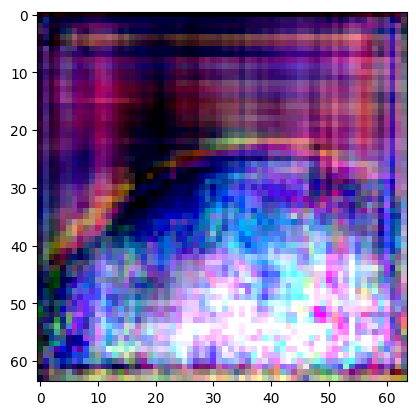

In [ ]:
plt.imshow(t2_test_single_image[:,:,13:16])

In [ ]:
t2_test_single_image = t2_test_images_batch[0].reshape(64,64,16)

# Below is the actual T2 weighted cropped image from the cross validation data. As, it can be observed that our network has become successful in generating synthetic translated images similar to actual T2 weighted cropped images.

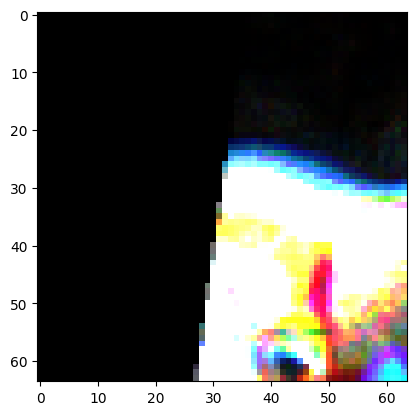

In [ ]:
plt.imshow(t2_test_single_image[:,:,13:16])